# Text Classification using word2vec
> Feature: Word2Vec (using Gensim tool)

File Name: GKB_Text_Classification_Word2vec

Created Date: 1 March 2017

Author: Boya Chen

Purpose: Machine Learning Experiments and Results Generation (word2Vec)

Enviornment: Python [2.7.10] ; IPython [5.3.0]

Dependencies: pandas [0.19.2] ; gensim [2.0.0] ; scikit-learn [0.18.1] ; numpy [1.12.1] ; scipy [0.19.0] ; matplotlib [2.0.0] 

# 1 - Reading CSV and do pre-processing

In [33]:
from collections import Counter, defaultdict
import csv, json
import random
from time import time
import gensim, logging, os
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import pandas as pd
from pandas.tools.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs

In [9]:
t0 = time(); print "[1 | Start Data Preprocessing] ... ...";

# Reading Training Data
GEO = 0
APP = 1
TOPIC = GEO

DATASET_PATH = './dataset.txt'
CLEANED_SENTENCES_PATH = "./dataset_cleaned_sentences_93994.csv"
POS_TAGS_PATH = './dataset_pos_tags_93994.csv'
ENTITY_OSMINFO_PATH = "./entities_set.json"

# Reading Dataset
content = []
with open(DATASET_PATH, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        content.append(row)

# Reading entities' OSM info
with open(ENTITY_OSMINFO_PATH, "r") as f_j:
    ent_with_info = json.load(f_j)

# Building a Name to Node index: Entity Name --> Entity ID
name_to_node = defaultdict()
for key in ent_with_info:
    try:
        name_to_node[ent_with_info[key]['tag']['name']] = key
    except:
        continue

##########  
# Labels #
##########

# Acquire the list of labels
labels = []
for item in content:
    labels.append(item[TOPIC])

# Acquire a set of indexes of Positibe and Negative labelled 'docs'
indexes_of_true = [n for n,l in enumerate(labels) if l == 't']
indexes_of_false = [n for n,l in enumerate(labels) if l == 'f']

#############  
# Sentences #
#############

# Acquire raw sentences
sents = []
for item in content:
    sents.append(item[2])
    
# Reading Cleaned Sentences
cleaned_sents = []
with open(CLEANED_SENTENCES_PATH, 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        cleaned_sents.append(row)

ent_sents = [] # <-- OSM ID for each sentence
type_sents = [] # <-- OSM type for each sentence
for item in content:
    ent_sents.append(item[3])
    try:
        type_sents.append(ent_with_info[item[3]]['ent_type'])
    except:
        type_sents.append([])
        
t0 = time(); print "[1 | DONE]", time()-t0, "s"

[1 | Start Data Preprocessing] ... ...
[1 | DONE] 0.000405073165894 s


# 2 - Loading and Building Word Models

Using Gensim tool, we can load exsited model or building a new model based on designated corpus

In [11]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
corpus = cleaned_sents[:]
# Reading Word2Vec Model
fname = 'wiki_corpus_300.model'
is_overwrite = 0 # <---- You can choose to load or re-build the model
if os.path.exists(fname) and is_overwrite == 0:
    # load the file if it has already been trained, to save repeating the slow training step below
    model = gensim.models.Word2Vec.load(fname)
else:
    # can take a few minutes, grab a cuppa
    model = gensim.models.Word2Vec(corpus, size=300, min_count=1, workers=4, iter=50) 
    model.save(fname)

2017-06-05 01:03:38,478 : INFO : loading Word2Vec object from wiki_corpus_300.model
2017-06-05 01:03:38,830 : INFO : loading wv recursively from wiki_corpus_300.model.wv.* with mmap=None
2017-06-05 01:03:38,831 : INFO : loading syn0 from wiki_corpus_300.model.wv.syn0.npy with mmap=None
2017-06-05 01:03:38,906 : INFO : setting ignored attribute syn0norm to None
2017-06-05 01:03:38,908 : INFO : loading syn1neg from wiki_corpus_300.model.syn1neg.npy with mmap=None
2017-06-05 01:03:39,082 : INFO : setting ignored attribute cum_table to None
2017-06-05 01:03:39,084 : INFO : loaded wiki_corpus_300.model


In [12]:
# Loading Pre-built Models for more supportive experiments [Time-Consuming Warning!!!!]
t0=time(); print "[Loading Model] ... ..."
model_ext_200 = KeyedVectors.load_word2vec_format("/Users/boyachen/Downloads/glove.6B/genism.wikivec_200d", binary= False)
model_ext_300 = KeyedVectors.load_word2vec_format("/Users/boyachen/Downloads/glove.6B/genism.wikivec_300d", binary= False)
print "[Finished!]:", time()-t0, "s"

In [37]:
t0=time(); print "[Applying the word2vec model to training data] ... ..."

cut_num = 17000 # Number of Labelled Docs

words_with_t = []
for i, sent in enumerate(corpus): 
    if labels[i] == 't':
        words_with_t.extend(sent)
words_with_t = list(set(words_with_t))

# sent_matrix = np.array([model[word] for word in cleaned_sents[0] if word in model])
# length = sent_matrix.shape[0]
# dimen = sent_matrix.shape[1]
# center = np.array([sum(sent_matrix[:,i])/(np.var(np.array(sent_matrix[:,i]))) for i in range(dimen)])

vector_model = model
dimen = 300
corpus_matrix = []
for i, sent in enumerate(cleaned_sents[:]):
    try:
        if i % 5000 == 0:
            print i, 'done.'
        if sent == []:
            corpus_matrix.append(np.zeros((1,dimen))[0])
            continue
        sent_matrix = np.array([vector_model[word] for word in sent if word in model])
        length = sent_matrix.shape[0]
        # Get a weighted average of all words from the document
        center = [sum(sent_matrix[:,i]) / length for i in range(dimen)]
        corpus_matrix.append(center)
    except:
        corpus_matrix.append(np.zeros((1,dimen))[0])

print "[DONE]", time()-t0, "s"

t_dataset = np.array(corpus_matrix[:cut_num])
t_labels = labels[:cut_num]

# The rest data will be the part for prediction
p_dataset = np.array(corpus_matrix[cut_num:])
# p_labels = labels[17000:]

[Applying the word2vec model to training data] ... ...
0 done.
5000 done.
10000 done.
15000 done.
20000 done.
25000 done.
30000 done.
35000 done.
40000 done.
45000 done.
50000 done.
55000 done.
60000 done.
65000 done.
70000 done.
75000 done.
80000 done.
85000 done.
90000 done.
[DONE] 182.634171009 s


## ! ---------- Imbalance Handling ---------- !

In [38]:
indexes_of_true_r = [n for n in indexes_of_true if n < t_dataset.shape[0]]
indexes_of_false_r = [n for n in indexes_of_false if n < t_dataset.shape[0]]
random.shuffle(indexes_of_false_r)
indexes_of_false_r = indexes_of_false_r[:len(indexes_of_true_r) * 2]

indexes_of_r = list(sorted(indexes_of_true_r + indexes_of_false_r))
np.random.shuffle(indexes_of_r) # randomly shuffle the order

t_dataset_r = np.array([t_dataset[i] for i in range(len(t_labels)) if i in indexes_of_r])
t_labels_r = [t_labels[i] for i in range(len(t_labels)) if i in indexes_of_r]

print "size of positive training dataset:", len(indexes_of_true_r)
print "size of negative training dataset:", len(indexes_of_false_r)

size of positive training dataset: 1016
size of negative training dataset: 2032


## Visualizing Multidimensional Data
- Visulation 1: All Dataset (PCA Plotting)
- Visulation 2: Balanced Dataset (PCA Plotting)
- Visulation 3: Parallel Coordinates

In [24]:
# Normalization Function
def x_norm(array):
    return (array - min(array)) / (max(array) - min(array)) if (max(array) - min(array)) !=0 else array

### Visulation 1: All Dataset (PCA Plotting)

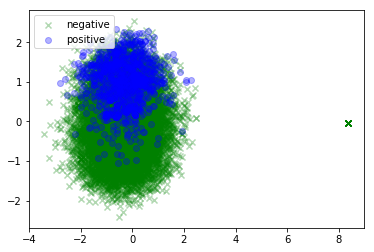

In [23]:
t_dataset_norm = np.array([x_norm(r) for r in t_dataset])

pca = sklearnPCA(n_components=2)
transformed = pca.fit_transform(t_dataset_norm)

transformed_true = []
transformed_false = []
for i in range(len(transformed)):
    if labels[i] == "t":
        transformed_true.append(list(transformed[i]))
    else:
        transformed_false.append(list(transformed[i]))

transformed_true = np.array(transformed_true)
transformed_false = np.array(transformed_false)

color1, marker1 = "green", 'x'
color2, marker2 = "blue", 'o'

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1, alpha=0.3)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2, alpha = 0.3)

plt.legend(loc=2)
plt.show()

### Visulazation 2: Balanced Dataset (PCA Plotting)

We can see the difference between two classes is more obvious after handling the dataset imbalance

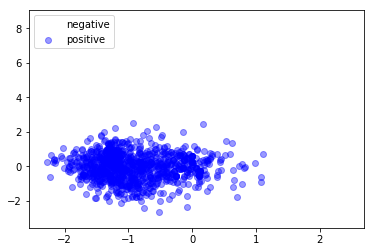

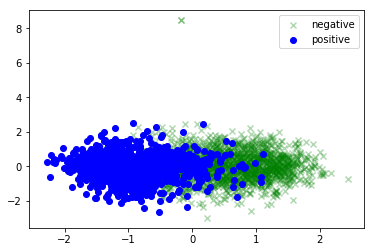

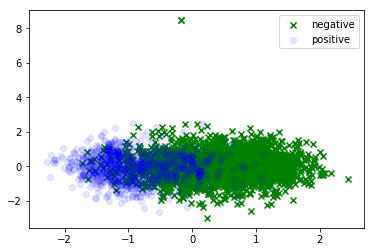

In [25]:
t_dataset_norm = np.array([x_norm(r) for r in t_dataset_r])

pca = sklearnPCA(n_components=2)
transformed = pca.fit_transform(t_dataset_norm)

transformed_true = []
transformed_false = []
for i in range(len(transformed)):
    if t_labels_r[i] == "t":
        transformed_true.append(list(transformed[i]))
    else:
        transformed_false.append(list(transformed[i]))

transformed_true = np.array(transformed_true)
transformed_false = np.array(transformed_false)

color1, marker1 = "green", 'x'
color2, marker2 = "blue", 'o'

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1, alpha=0)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2, alpha = 0.4)

plt.legend(loc=2)
plt.show()

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1, alpha = 0.3)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2)

plt.legend()
plt.show()

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2, alpha = 0.1)

plt.legend()
plt.show()

### Visulation 3: Parallel Coordinates

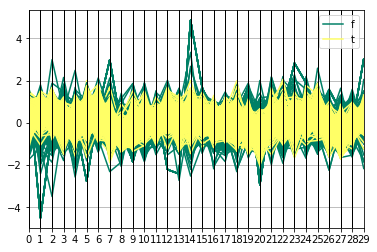

In [32]:
df = pd.concat([pd.DataFrame(t_dataset_r[:,:30]), pd.DataFrame(t_labels_r, columns=["label"])], axis=1)
parallel_coordinates(df, "label", colormap="summer")
plt.show()

# 3 - Validation

In [35]:
def check_results(predictions, classifications):
    lab = ['t', 'f']
    print classification_report(classifications, predictions, labels=lab)

############################
# Classifiers from Sklearn #
############################
# # Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()
# # Support Vector Machine
from sklearn import svm
clf_svm = svm.LinearSVC(C=0.1)
# # Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()
# # Random Foreset Classifier
from sklearn.ensemble import RandomForestClassifier
clf_rfc = RandomForestClassifier()
# # Bagging Classifier
from sklearn.ensemble import BaggingClassifier
clf_bag = BaggingClassifier()
# # K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
clf_knc = KNeighborsClassifier(n_neighbors=3)

test_clf = [clf_svm, clf_rfc, clf_knc]

t1 = time()
print "[Job Start]"
for clf in test_clf:
#     print 'CLASSIFIER -->', str(clf)
#     print '------- CROSS VALIDATION --------'
    crossval_predicted = cross_val_predict(clf, t_dataset_r, t_labels_r, cv=10)
    check_results(crossval_predicted, t_labels_r)
    print '----------------------------------------------------'
    print '\n'
    
print "[Job Done]:", time()-t1, "s"

[Job Start]
             precision    recall  f1-score   support

          t       0.85      0.88      0.86      1016
          f       0.94      0.92      0.93      2032

avg / total       0.91      0.91      0.91      3048

----------------------------------------------------


             precision    recall  f1-score   support

          t       0.91      0.78      0.84      1016
          f       0.90      0.96      0.93      2032

avg / total       0.90      0.90      0.90      3048

----------------------------------------------------


             precision    recall  f1-score   support

          t       0.84      0.88      0.86      1016
          f       0.94      0.92      0.93      2032

avg / total       0.91      0.90      0.91      3048

----------------------------------------------------


[Job Done]: 12.0369699001 s


# Results Generation

In [86]:
# Fitting the classifier
real_predictions = clf_svm.fit(t_dataset_r, t_labels_r).predict(p_dataset)
new_all_labels = labels[:cut_num] + list(real_predictions[:])

# Collecting all labelled sentences and store in a dictionary using OSM_IDs as keys
entities_with_sentences = defaultdict()
for l, row in enumerate(new_all_labels):
    if row == 't':
        node_id = content[l][3]
        sentence = sents[l]
        if node_id in  entities_with_sentences:
            entities_with_sentences[content[l][3]].append(sentence)
        else:
            entities_with_sentences[content[l][3]] = [sentence]

In [120]:
# Reading a GEOJSON format dictionary without "description" attribute.
ENT_GEPJSON_PATH = "./ent_geojson_3377.json"
with open(ENT_GEPJSON_PATH, "r") as inpt:
    ent_geojson_set = json.load(inpt)

# Transform the ent_geojson_Set to a dictionary using OSM ID as key in order to store all
# informative sentences
ent_geojson_dict = defaultdict()
for feat in ent_geojson_set["features"]:
    ent_geojson_dict[feat['properties']['om_id']] = feat # <-- Copy the reference so we don't need to create
                                                         # a new GEOJSON format dictionary again
    
# looking through the entities_with_sentences and store in the ent_geojson_dict.
for key in entities_with_sentences:
    if "way" in key:
        if int(key[4:]) in ent_geojson_dict:
            ent_geojson_dict[int(key[4:])]['properties']['sentences'] = entities_with_sentences[key]
    else:
        if int(key[5:]) in ent_geojson_dict:
            ent_geojson_dict[int(key[5:])]['properties']['sentences'] = entities_with_sentences[key]

Now check the final ouput, and using json.dump() to store the data.

In [124]:
ent_geojson_set

{u'features': [{u'geometry': {u'coordinates': [153.42305556, -27.97388889],
    u'type': u'Point'},
   u'properties': {u'name': u'Nerang River',
    u'om_id': 252989358,
    'sentences': ['The Nerang River is a perennial river located in South East Queensland, Australia.',
     'Its catchment lies within the Gold Coast local government area and covers an area of 490 square kilometres (190 sq mi).',
     'The river is approximately 62 kilometres (39 mi) in length.',
     '== Course and features == The Nerang River rises in the McPherson Range in the Numinbah Valley on the New South Wales and Queensland border and heads north, then east where it flows through Nerang and reaching its mouth in the Gold Coast Broadwater at Sou',
     'The Nerang River catchment is the largest and most significant river system on the Gold Coast.',
     'Two man-made lakes are also located in the lower catchment, including the Lake Rosser and Lake Capabella.',
     "The river's mouth was once located much fur

In [126]:
OUTPUT_PATH = "./ent_geojson_3377_with_sents.json"
with open(OUTPUT_PATH, "wt") as output:
    json.dump(ent_geojson_set, output)